In [1]:
import numpy as np
import pandas as pd 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from scipy.stats import entropy
from tqdm.notebook import tqdm, trange
import statsmodels.api as sm
import statistics 
from scipy.stats import gaussian_kde
from sklearn import preprocessing
import lowess as lo

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ModuleNotFoundError: ignored

In [ ]:
! pip install lowess

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
total_playcount = np.load("/content/drive/My Drive/MSc Statistics/total_playcount.npy")
distinct_songs = np.load("/content/drive/My Drive/MSc Statistics/distinct_songs.npy", allow_pickle=True)
distinct_artists = np.load("/content/drive/My Drive/MSc Statistics/distinct_artists.npy")
shannon_art = np.load("/content/drive/My Drive/MSc Statistics/shannon-artist.npy")
pop_score = np.load("/content/drive/My Drive/MSc Statistics/pop_score.npy")
relative_art = np.load("/content/drive/My Drive/MSc Statistics/KL-artist.npy")
gini_index_art = np.load("/content/drive/My Drive/MSc Statistics/gini-artist.npy")
hill_no_art = np.load("/content/drive/My Drive/MSc Statistics/hill-artist.npy")
toy_triplets = np.load("/content/drive/My Drive/MSc Statistics/toy_triplets.npy", allow_pickle=True)
toy_triplets = pd.DataFrame(toy_triplets, columns = ["UserId", "SongId", "Count", "TrackId", "Artist", "Song" ])

centre = np.load("/content/drive/My Drive/MSc Statistics/centroid_norm.npy", allow_pickle=True)
TS_SS_nonorm = np.load("/content/drive/My Drive/MSc Statistics/TS-SS.npy")
TS_SS_norm = np.load("/content/drive/My Drive/MSc Statistics/TS-SS2.npy")

gini_index = np.load("/content/drive/My Drive/MSc Statistics/gini_index.npy")
hill_no = np.load("/content/drive/My Drive/MSc Statistics/hill_no.npy")
shannon = np.load("/content/drive/My Drive/MSc Statistics/shannon.npy")
relative = np.load("/content/drive/My Drive/MSc Statistics/relative.npy")

# embedded vectors data
embeds = np.load("/content/drive/My Drive/MSc Statistics/track-embeddings-v2.npz", allow_pickle=True)


proximity = np.load("/content/drive/My Drive/MSc Statistics/proximity.npy")

In [ ]:
# Squared norm of the centroid is the GS score
GS = []
for x in centre:
  GS.append(np.linalg.norm(x))

In [ ]:
def plot(p,q, xlab, ylab, filename, frac=0.2):
  # Plots scatterplot with mass gradient and LOwESS
  # p - x variable
  # q - y variable

  # stacking data for the density gradient
  xy = np.vstack([p,q])
  # calling 
  z = gaussian_kde(xy)(xy)

  idx = z.argsort()
  x, y, z = p[idx], q[idx], z[idx]

  df = pd.DataFrame({'x': x, 'Raw': y})
  df["pred"] = lo.lowess(df["Raw"], df["x"], frac, 2)

  # sorting so that could plot a somehow monotonic line
  sorted_index = np.argsort(df["Raw"])
  X_sort = df["Raw"][sorted_index]
  y_sort = df["pred"][sorted_index]  

  fig, ax = plt.subplots()
  # main scatter
  ax.scatter(df["Raw"], df["x"], c=z, s=50, edgecolor='', cmap=plt.cm.summer)
  # LOWESS 
  ax.plot(X_sort, y_sort, "r", label="LOWESS")
  leg = ax.legend(loc=7)
  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.savefig(filename, format = "png", transparent = True)
  plt.show()

In [ ]:
def plot_hill(p,q, xlab, ylab, filename):
  # Plots scatterplot with mass gradient and LOESS
  # p - x variable
  # q - y variable
  xy = np.vstack([p,q])
  z = gaussian_kde(xy)(xy)

  idx = z.argsort()
  x, y, z = p[idx], q[idx], z[idx]

  m, b = np.polyfit(p, q, 1)

  fig, ax = plt.subplots()
  ax.scatter(x, y, c=z, s=50, edgecolor='', cmap=plt.cm.summer)
  ax.plot(p, m*p + b, label="OLS", color="r")
  leg = ax.legend(loc=1)
  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.savefig(filename, format = "png", transparent = True)
  plt.show()

In [ ]:
# normalizing the vectors to have a unit norm as in the paper
emb_norm = preprocessing.normalize(embeds["beta"], norm='l2')
# moving to pandas to exploit indexing
pan_emb = pd.DataFrame(emb_norm)

In [ ]:
# check which songs are remaining in the subsample and leaving only those
songs = toy_triplets["SongId"].unique().tolist()
songs_pd = pd.DataFrame(songs, columns=["SongId"])
embeds_songs = pd.DataFrame(embeds["mapping"], columns=["SongId"])
embeds_songs["Location"] = embeds_songs.index

embeds_songs = pd.merge(left = embeds_songs, right = songs_pd, left_on="SongId", right_on="SongId")

In [4]:
users = toy_triplets["UserId"].unique().tolist()

In [ ]:
index = np.argwhere(np.isnan(TS_SS_nonorm))
TS_SS_nonorm2 = np.delete(TS_SS_nonorm, index)
print(index)

[[ 604]
 [8972]
 [9221]]


In [ ]:
GS2 = np.delete(GS, index)
relative2 = np.delete(relative, index)
relative_art2 = np.delete(relative_art, index)
shannon2 = np.delete(shannon, index)
shannon_art2 = np.delete(shannon_art, index)
gini2 = np.delete(gini_index, index)
gini_art2 = np.delete(gini_index_art, index)
hill2 = np.delete(hill_no, index)
hill_art2 = np.delete(hill_no_art, index)
TS_SS_nonorm2 = np.delete(TS_SS_nonorm, index)
TS_SS_norm2 = np.delete(TS_SS_norm, index)
users2 = np.delete(users, index)
distinct_artists2 = np.delete(distinct_artists, index)
distinct_songs2 = np.delete(distinct_songs[:,1], index)

# Splitting to training testing data

In [ ]:
train = pd.DataFrame(columns=["UserId", "SongId", "Count", "Artist", "Song"])
test = pd.DataFrame(columns=["UserId", "SongId", "Count", "Artist", "Song"])
for i in tqdm(users2):
  a = toy_triplets[["UserId", "SongId", "Count", "Artist", "Song"]][toy_triplets["UserId"]==i]

  shuffle_df = a.sample(frac=1)
  train_size = int(0.8 * len(a))
  train_one = shuffle_df[:train_size]
  test_one = shuffle_df[train_size:]

  train = pd.concat([train, train_one])
  test = pd.concat([test, test_one])

In [ ]:
np.save("train",train)
np.save("test", test)

# Getting the average track

Now need to calculate centroids as before. Normalise data beforehands

In [ ]:
# first try to get centroid
def centroid(p,w):
  # assume we have a joint np array.
  # Joint means all song vectors are stacked vertically
  # w gotta be a n_i x 1 np array
  weighted = p * w
  joint = weighted.sum(axis=0)
  return joint/np.sum(w)

In [ ]:
centre_train = []
for i in tqdm(users2):
  songs_loop = train[["SongId", "Count"]][train["UserId"]==i]
  # merging with the location as found in the embeds["mapping"]
  loc_merge = pd.merge(left = embeds_songs, right = songs_loop, left_on="SongId", right_on="SongId")
  loc_temp = loc_merge["Location"].tolist()
  # those location correspond the the right songs. Extracting them
  extract_vec = pan_emb.iloc[loc_temp]
  # function centroid requires weight vector to be a column vector
  weights = songs_loop["Count"].to_numpy().reshape(-1,1)
  # appending function values
  centre_train.append(centroid(extract_vec.to_numpy(), weights))

In [ ]:
np.save("centre_train", centre_train)

# Compute average cosine similarity with the tests songs

from sklearn.metrics.pairwise import cosine_similarity

In [1]:
from sklearn.metrics.pairwise import cosine_similarity

proximity = []
for i, mu in tqdm(zip(users2, centre_train)):
  songs_loop = test[test["UserId"]==i]
  loc_merge = pd.merge(left = embeds_songs, right = songs_loop, left_on="SongId", right_on="SongId")
  loc_temp = loc_merge["Location"].tolist()
  # those location correspond the the right songs. Extracting them
  extract_vec = pan_emb.iloc[loc_temp].to_numpy()

  cosines = []
  for j in extract_vec:
    cosines.append(cosine_similarity(j.reshape(1, -1), mu.reshape(1, -1)))
  proximity.append(np.sum(cosines)/len(cosines))


NameError: ignored

In [2]:
np.save("proximity", proximity)

NameError: ignored

In [ ]:
plt.hist(proximity, bins=40)

In [ ]:
pd.DataFrame(proximity).describe()

# Scatters

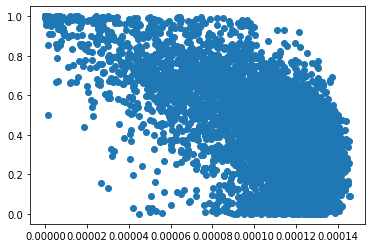

In [ ]:
plt.scatter(TS_SS_norm2, proximity)

In [ ]:
Y = proximity
X = np.column_stack((TS_SS_norm2, TS_SS_norm2**2))
#X = np.column_stack((X, shannon2))
X = sm.add_constant(X)
model = sm.OLS(Y, X.astype("float"))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     4370.
Date:                Mon, 24 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:47:40   Log-Likelihood:                 4382.2
No. Observations:                9997   AIC:                            -8758.
Df Residuals:                    9994   BIC:                            -8737.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9503      0.013     75.641      0.0

In [ ]:
parameters = results.params

In [ ]:
pred = results.predict(X)

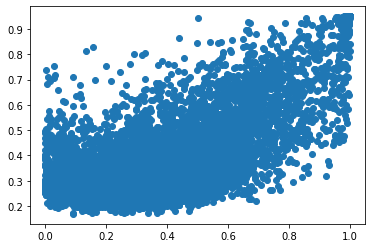

In [ ]:
plt.scatter( Y, pred)

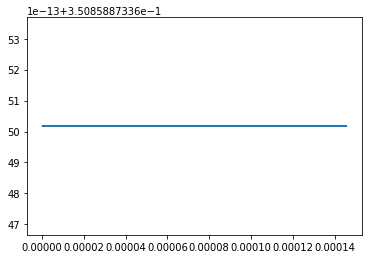

In [ ]:
from scipy.optimize import curve_fit

def func(X,a,  b, c ):
  return (a + b * X + c * X**2)

popt, pcov = curve_fit(func, TS_SS_norm2, proximity, bounds=(0, [3., 1., 0.5]))

plt.plot(TS_SS_norm2, func(TS_SS_norm2, *popt))

In [ ]:
y = func(TS_SS_norm2, parameters[0], parameters[1], parameters[2])

df = np.transpose(pd.DataFrame([y, TS_SS_norm2]))

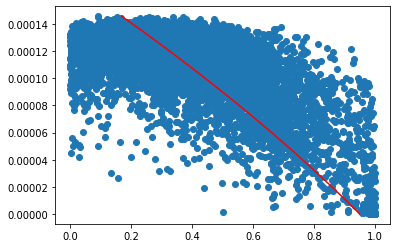

In [ ]:
sorted_index = np.argsort(df[0])
X_sort = df[0][sorted_index]
y_sort = df[1][sorted_index]  

plt.scatter(proximity, TS_SS_norm2)
plt.plot(X_sort, y_sort, "r")

In [ ]:
from sklearn.svm import SVR

fit = SVR(C = 0.1, kernel="poly", degree=2)
fit.fit(TS_SS_norm2[:8000].reshape(-1,1),Y[:8000])

SVR(C=0.1, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
a = fit.predict(TS_SS_norm2[8000:].reshape(-1,1))

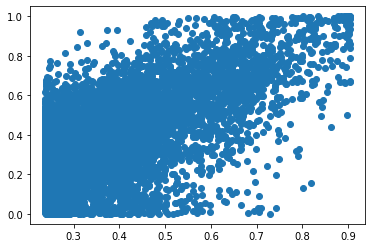

In [ ]:
plt.scatter(a, Y)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(a, Y[8000:], squared=False)

NameError: ignored

In [ ]:
from sklearn.svm import SVR

fit = SVR(C = 0.1, kernel="linear")
fit.fit(GS2[:8000].reshape(-1,1),Y[:8000])

SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
b = fit.predict(GS2[8000:].reshape(-1,1))

In [ ]:
mean_squared_error(b, Y[8000:], squared=False)

0.15467715322518763

# Box Cox transformation

In [ ]:
from scipy import stats

x, lamb = stats.boxcox(GS2)

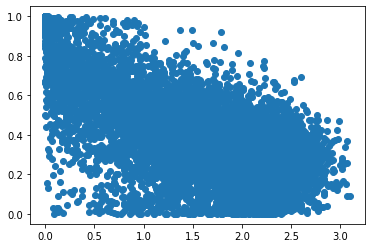

In [ ]:
plt.scatter(ts_Tran, proximity)

In [ ]:
ts_Trans =  (TS_SS_norm2*10000)**3

Y = proximity
X = np.column_stack((GS2, distinct_artists2))
#X = np.column_stack((X, shannon2))
#X = (TS_SS_norm2*10000)**3
#X = GS2
X = sm.add_constant(X)
model = sm.OLS(Y, X.astype("float"))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     4772.
Date:                Tue, 25 Aug 2020   Prob (F-statistic):               0.00
Time:                        08:21:55   Log-Likelihood:                 4592.0
No. Observations:                9997   AIC:                            -9178.
Df Residuals:                    9994   BIC:                            -9156.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2014      0.006    -31.536      0.0

In [ ]:
y = results.predict(X)

In [ ]:
mean_squared_error(y, Y, squared=False)

0.1528527837508499

# Scatters

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


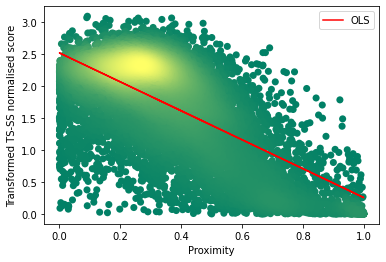

In [ ]:
plot(ts_Trans, ts_Trans, "Proximity", "Transformed TS-SS normalised score", "TS_SS_NT_prox" )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


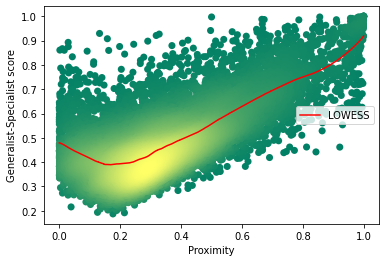

In [ ]:
plot(GS2, proximity, "Proximity", "Generalist-Specialist score", "GS_prox" )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


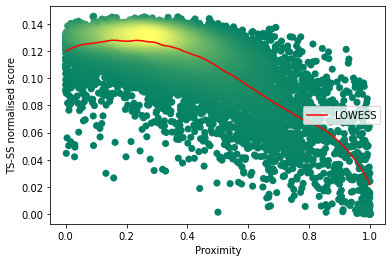

In [ ]:
plot(TS_SS_norm2*1000, proximity, "Proximity", "TS-SS normalised score", "TS_SS_N_prox")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


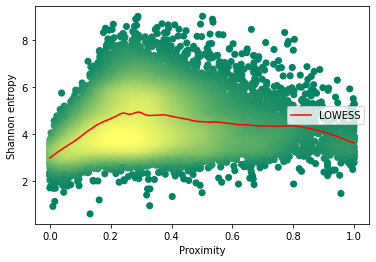

In [ ]:
plot(shannon2, proximity, "Proximity", "Shannon entropy", "Shannon_prox")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


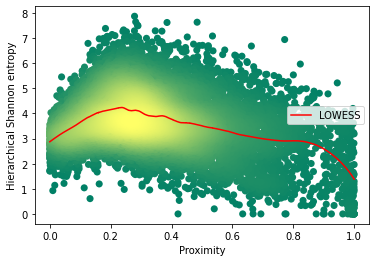

In [ ]:
plot(shannon_art2, proximity, "Proximity", "Hierarchical Shannon entropy", "Shannon_art_prox")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


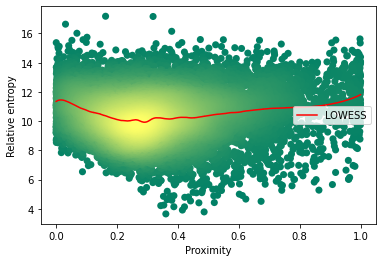

In [ ]:
plot(relative2, proximity, "Proximity", "Relative entropy", "Relative_prox")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


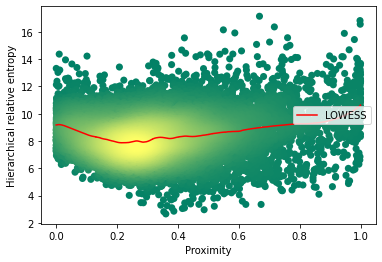

In [ ]:
plot(relative_art2, proximity, "Proximity", "Hierarchical relative entropy", "Relative_art_prox")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


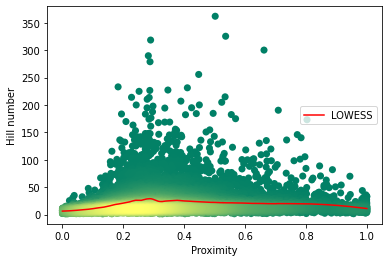

In [ ]:
plot(hill2, proximity, "Proximity", "Hill number", "Hill_prox")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


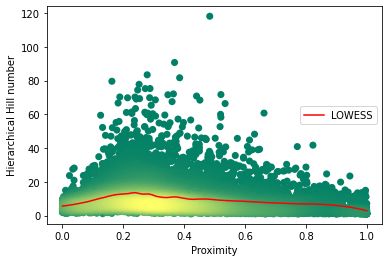

In [ ]:
plot(hill_art2, proximity, "Proximity", "Hierarchical Hill number", "Hill_art_prox")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


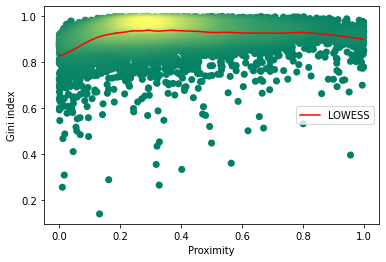

In [ ]:
plot(gini2, proximity, "Proximity", "Gini index", "Gini_prox")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


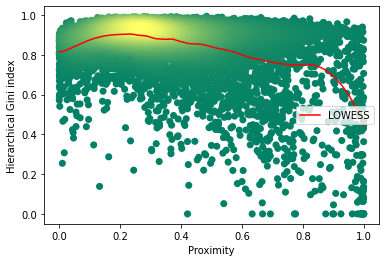

In [ ]:
plot(gini_art2, proximity, "Proximity", "Hierarchical Gini index", "Gini_art_prox")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


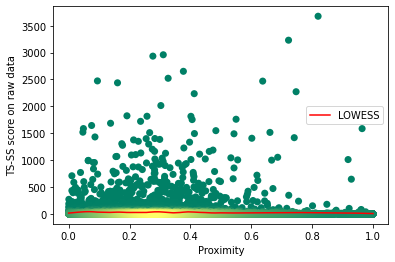

In [ ]:
plot(TS_SS_nonorm2, proximity, "Proximity", "TS-SS score on raw data", "TS_SS_R_prox")

# LOWESS

In [ ]:
  # GS
  df = pd.DataFrame({'x': proximity, 'Raw': GS2})
  df["pred"] = lo.lowess(df["Raw"], df["x"], 0.2, 2)
  GS_hat = df["pred"]

In [ ]:
mean_squared_error(df["pred"], proximity, squared=False)

0.1544165012350716

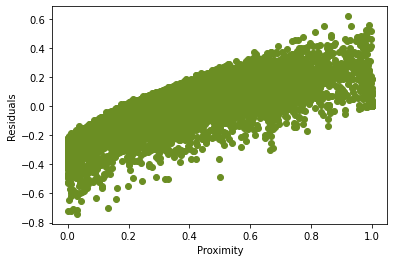

In [ ]:
plt.scatter(proximity, proximity - GS_hat, color="olivedrab")
plt.xlabel("Proximity")
plt.ylabel("Residuals")
plt.savefig("GS_res")

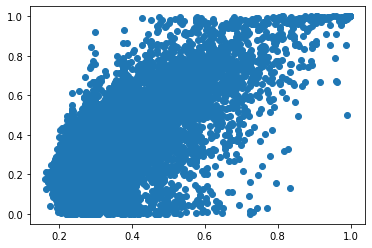

In [ ]:
plt.scatter(df["pred"], proximity)

In [ ]:
  # TS_SS
  df = pd.DataFrame({'x': proximity, 'Raw': TS_SS_norm2*1000})
  df["pred"] = lo.lowess(df["Raw"], df["x"], 0.2, 2)
  TS_hat = df["pred"]

In [ ]:
mean_squared_error(df["pred"], proximity, squared=False)

0.15483412062162688

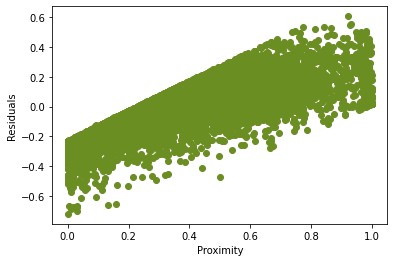

In [ ]:
plt.scatter(proximity, proximity - TS_hat, color="olivedrab")
plt.xlabel("Proximity")
plt.ylabel("Residuals")
plt.savefig("TSSS_res")

# Misc

In [15]:
toy_triplets[toy_triplets["UserId"]==users[8536]].groupby(["Artist"])["Count"].sum().to_latex()

"\\begin{tabular}{lr}\n\\toprule\n{} &  Count \\\\\nArtist                                      &        \\\\\n\\midrule\nAdriana Calcanhotto                         &      1 \\\\\nAmerica                                     &      1 \\\\\nAndres Calamaro                             &      1 \\\\\nAntonio Vivaldi                             &      1 \\\\\nAventura                                    &      1 \\\\\nBedouin Soundclash                          &      1 \\\\\nBjörk                                       &      1 \\\\\nBrant Bjork                                 &      1 \\\\\nBuju Banton                                 &      1 \\\\\nBusta Rhymes / Swizz Beatz                  &      1 \\\\\nCarlos Santana \\& Mahavishnu John McLaughlin &      2 \\\\\nCartola                                     &      1 \\\\\nCirrus                                      &      1 \\\\\nCounting Crows                              &      1 \\\\\nCéline Dion                                 &     

In [13]:
distinct_artists[6918]

50